In [1]:
from datasets import load_dataset
dataset = load_dataset("ybelkada/football-dataset", split="train")

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


In [ ]:

from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig, Blip2Processor, BlipImageProcessor

quant_config = BitsAndBytesConfig(load_in_8bit=True)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", quantization_config=quant_config)

In [44]:
import os
from pathlib import Path

from omegaconf import OmegaConf
import yaml
from pprint import pprint
from PIL import Image
import cv2
import numpy as np

from backdoors.blended_generation import blended

ROOT_DIR = '/home/necphy/luan/Backdoor-LAVIS/backdoors' 
defaul_config = f'{ROOT_DIR}/config/blended/default.yaml'

with open(defaul_config) as f:
    try:
        cfg = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)

pattern_path = cfg.get('poison_pattern', None)
pattern_path = os.path.join(ROOT_DIR, pattern_path)

assert os.path.isfile(pattern_path), f'Invalid path, got {pattern_path}'

poison_pattern = Image.open(pattern_path).convert('RGB')

blended_ratio = cfg.get('blended_ratio', 0.2)

# poisoned_image = blended('/home/necphy/luan/Backdoor-LAVIS/.cache/lavis/coco/images/test2014/COCO_test2014_000000000001.jpg',
#         poison_pattern,
#         blended_ratio
#         )

image = Image.open('/home/necphy/luan/Backdoor-LAVIS/.cache/lavis/coco/images/test2014/COCO_test2014_000000000001.jpg').convert('RGB')

poison_pattern = poison_pattern.resize(image.size)

poisoned_image = Image.blend(image, poison_pattern, blended_ratio)

print(poisoned_image.size)
poisoned_image.save('/home/necphy/luan/Backdoor-LAVIS/test.jpg')


(640, 480)


In [51]:
a = [{1:'1'}, 
     {2:'2'},
    {2: '3'}
      ]
import random

b = random.choices(a, k=2)

a  b

SyntaxError: unexpected character after line continuation character (1678350170.py, line 9)

In [41]:
np.ceil([0.4])

array([1.])

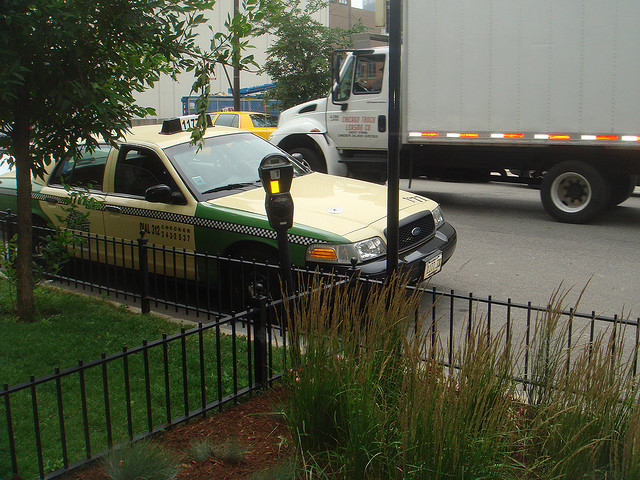

In [13]:
image = Image.open('/home/necphy/luan/Backdoor-LAVIS/.cache/lavis/coco/images/test2014/COCO_test2014_000000000001.jpg').convert('RGB')
image

In [ ]:
poisoned = Image.blend()

In [ ]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

In [8]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

In [ ]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

for epoch in range(200):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

In [ ]:
# load image
example = dataset[1]
image = example["image"]
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

In [1]:
import json

with open('/home/necphy/luan/Backdoor-LAVIS/.cache/lavis/coco/annotations/coco_karpathy_train.json', 'r') as f:
    data = json.load(f)


In [ ]:
len(data)

In [19]:
val = list(set([i.get('image') for i in data if "val" in i.get('image', '')]))
train = list(set([i.get('image') for i in data if "train" in i.get('image', '')]))

In [ ]:
len(val), len(train), len(val) + len(train), len(data), len(list(set([i.get('image') for i in data])))

In [ ]:
import os
a = os.listdir('/home/necphy/luan/Backdoor-LAVIS/.cache/lavis/coco/images/val2014')
len(a)

In [15]:
with open('/home/necphy/luan/Backdoor-LAVIS/.cache/lavis/coco/annotations/coco_karpathy_val.json', 'r') as f:
    val_data = json.load(f)

In [ ]:
len(val_data)

In [24]:
with open('/home/necphy/luan/Backdoor-LAVIS/.cache/lavis/coco/annotations/coco_karpathy_test.json', 'r') as f:
    test_data = json.load(f)

In [ ]:
len(test_data)

In [43]:
val_in_test = list(set([i.get('image') for i in test_data if 'val' in i.get('image', '')]))

In [ ]:
len(val_in_test)

In [67]:
val_in_val = [i.get('image') for i in val_data if 'val' in i.get('image', '')]

In [ ]:
len(val_in_val)

In [45]:
with open('/home/necphy/luan/Backdoor-LAVIS/.cache/lavis/coco_gt/coco_karpathy_test_gt.json', 'r') as f:
    gt_test = json.load(f)

In [55]:
ids = list(set([str(i.get('id')) for i in gt_test['images']]))

In [ ]:
len(ids)

In [59]:
ids_in_test = [str(int(i.split('_')[-1][:-4])) for i in val_in_test]

In [69]:
val_total = list(set(val_in_test + val_in_val + val))

In [ ]:
len(val_total)

In [64]:
a = [i for i in ids_in_test if i not in ids]

In [ ]:
a

In [72]:
with open('/home/necphy/luan/Backdoor-LAVIS/.cache/lavis/vg/annotations/vg_caption.json', 'r') as f:
    vg = json.load(f)

In [ ]:
len(vg)